<a href="https://colab.research.google.com/github/iveksl2/ds_skills/blob/master/time_series/Regime_Change_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Detecting Structural changes in blochain transaction time series - Sergey Mastitsky](https://medium.com/geekculture/detecting-structural-changes-in-blockchain-transaction-time-series-cf62bfea3e2a)

In [2]:
require(readr)

Loading required package: readr



In [3]:
tron_tx <- read_csv(file = "https://chilp.it/44bea1d")


Rows: 318 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): tx_count
dttm (1): timestamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(tron_tx)

timestamp,tx_count
<dttm>,<dbl>
2021-07-02 02:55:00,233
2021-07-02 02:55:03,234
2021-07-02 02:55:06,302
2021-07-02 02:55:09,313
2021-07-02 02:55:12,351
2021-07-02 02:55:15,291


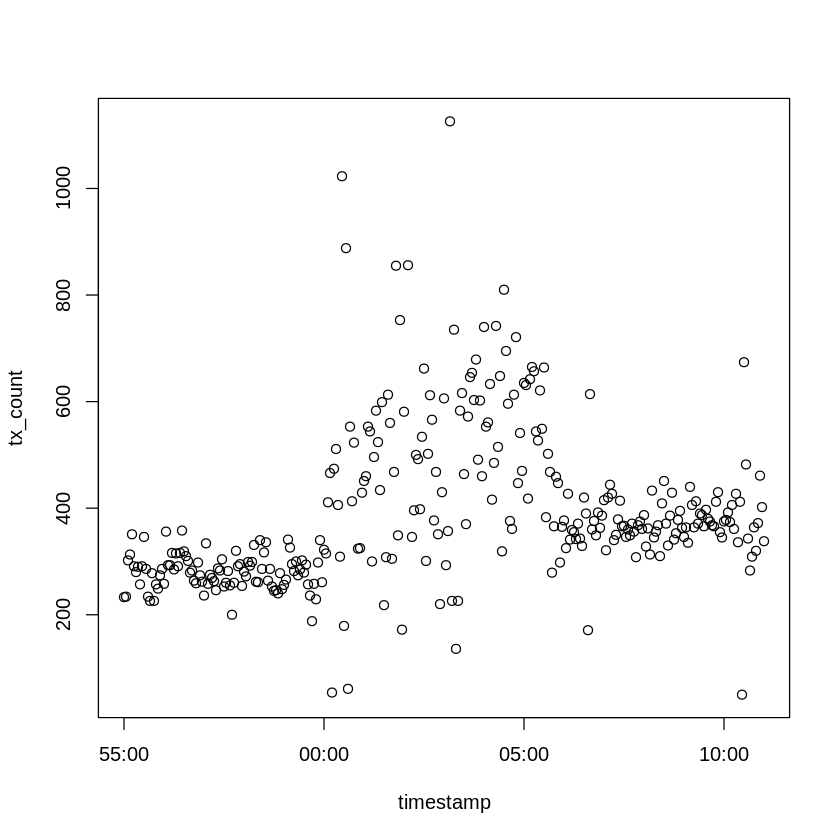

In [6]:
plot(tron_tx)

In [14]:
#install.packages('ecp')
require(ecp)

Loading required package: ecp

Loading required package: Rcpp



In [15]:
tron_cp <- e.divisive(as.matrix(tron_tx$tx_count))

In [16]:
tron_cp$estimates

[1]   1 103 166 212 319

In [17]:
tron_cp$p.values

[1] 0.005 0.005 0.005 0.770

In [18]:
get_cp <- function(x, true_cp = tron_tx[103, ]$timestamp) {
  
  cp <- e.divisive(as.matrix(x$tx_count))
  if (cp$k.hat == 1) return(NA)
  cp_idx <- cp$estimates[-c(1, length(cp$estimates))]
  if (length(cp_idx > 1)) cp_idx <- cp_idx[1]
  cp_timestamp <- x[cp_idx, ]$timestamp
  as.numeric(difftime(true_cp, cp_timestamp, units = "secs"))
}

In [22]:
#install.packages('tsibble')
#install.packages('slider')
require(slider)
require(purrr)
require(tsibble)
require(magrittr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘warp’


Loading required package: slider



In [23]:
# Convert data to the `tsibble` format for easier processing:
tron_tx <- as_tsibble(tron_tx, index = timestamp)
# Select the simulation period:
tx_subset <- tron_tx %>% 
  filter_index(. ~ "2021-07-02 03:03:21")
# Create sliding windows with 100 observations each:
windows <- tx_subset %>%
  slide(., .f = ~.x, .after = 99, .complete = TRUE) %>%
  compact()
# We have a total of 66 windows:
length(windows)
#> [1] 66
# Apply the E-Divisive algorithm to each window:
sim_result <- windows %>%
  map_dbl(.f = ~get_cp(.))

[1] 66

In [24]:
first_cp_window <- which(!is.na(sim_result))[1]
windows[[first_cp_window]]$timestamp %>% max()

[1] "2021-07-02 03:00:30 UTC"

In [25]:
sim_result[first_cp_window]


[1] 63